### LIBRARIES
---

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier

from datetime import datetime

import warnings

### EXPLORATORY DATA ANALYSIS
---

In [2]:
warnings.filterwarnings("ignore")

octasat = pd.read_csv('./data/octasat/OctaCSV.csv')
quintero = pd.read_csv('./data/quintero/QuinteroCSV.csv')

print("OCTASAT")
# print(octasat.head())
print(octasat.shape)
print(octasat.columns)
print(' - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
print("QUINTERO")
# print(quintero.head())
print(quintero.shape)
print(quintero.columns)

OCTASAT
(2474, 10)
Index(['latitude', 'longitude', 'neo_altitude', 'num_satellites',
       'hdc_temperature', 'bmp_temperature', 'humidity', 'pressure',
       'mpu_altitude', 'time'],
      dtype='object')
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
QUINTERO
(1624, 10)
Index(['latitude', 'longitude', 'neo_altitude', 'num_satellites',
       'hdc_temperature', 'bmp_temperature', 'humidity', 'pressure',
       'mpu_altitude', 'time'],
      dtype='object')


{'difference': 850, 'percent_difference': 34.36, 'df1': 2474, 'df2': 1624}


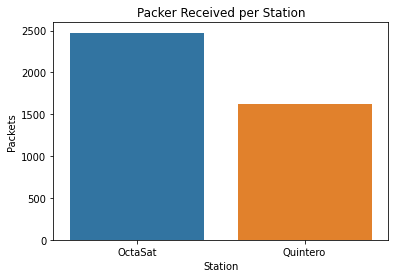

<Figure size 432x288 with 0 Axes>

In [3]:
def compare_data_loss(df1, df2, message=True):
    df1 = len(df1)
    df2 = len(df2)
    
    difference = abs(df1 - df2)
    percent_difference = round((difference / df1)*100, 2)

    if message:
        if difference > 0:
            message = 'Data loss: {0} ({1} %) of the packets.\nWith:\n\t- OctaSat -> {2}\n\t- Quintero -> {3}'.format(difference, percent_difference, df1, df2)
            return message
        else:
            message = 'No data loss.'
            return message
    else:
        obj = {
            'difference': difference,
            'percent_difference': percent_difference,
            'df1': df1,
            'df2': df2
        }
        return obj

data_loss_octasat_quintero = compare_data_loss(octasat, quintero, message=False)
print(data_loss_octasat_quintero)

sns.barplot(x=["OctaSat", "Quintero"], y=[data_loss_octasat_quintero['df1'], data_loss_octasat_quintero['df2']])
plt.title("Packer Received per Station")
plt.xlabel("Station")
plt.ylabel("Packets")
plt.show()
plt.clf()

Total mission time: 7 hour(s) 43 minute(s) and 01 second(s).


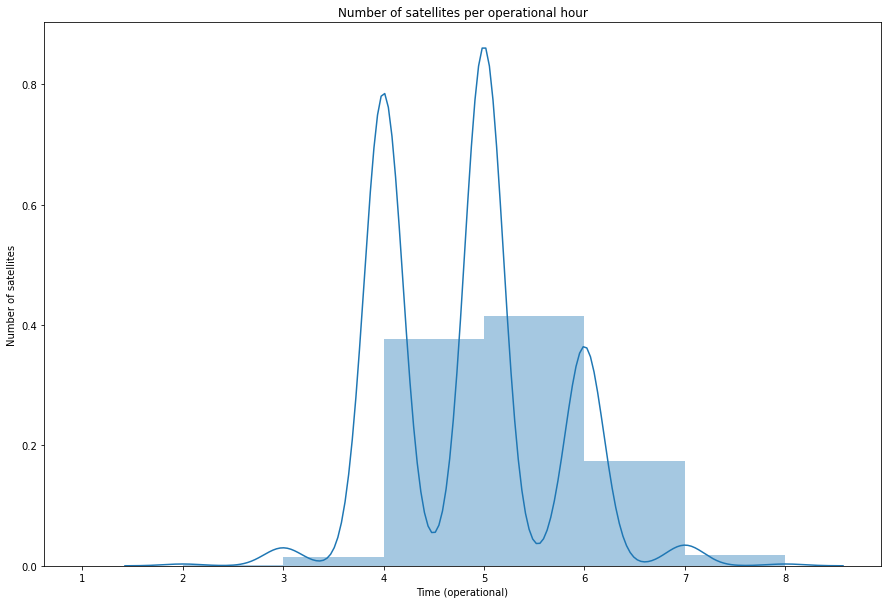

<Figure size 432x288 with 0 Axes>

In [4]:
def format_time(dataset, message=True, all_columns=False):
    time = dataset.time
    formated_time = time.apply(lambda x: datetime.strptime(x, '%d/%m, %H:%M:%S'))
    formated_time = formated_time.apply(lambda x: x.strftime('%H:%M:%S'))

    if all_columns:
        return formated_time

    begin = datetime.strptime(formated_time.iloc[0], '%H:%M:%S')
    final = datetime.strptime(formated_time.iloc[-1], '%H:%M:%S')
    H_M_S = str(final - begin).split(':')

    if message:
        total_mission_time_message = 'Total mission time: {0} hour(s) {1} minute(s) and {2} second(s).'.format(H_M_S[0], H_M_S[1], H_M_S[2])
        return total_mission_time_message
    else:
        total_mission_time = final - begin
        return total_mission_time

print(format_time(octasat))


satellite_data = octasat[octasat.num_satellites != 0]
plt.figure(figsize=(15, 10))
satellite_data["formated_time"] = format_time(satellite_data, all_columns=True)
satellite_data_to_plot = satellite_data.groupby('formated_time')['num_satellites'].mean()
sns.distplot(satellite_data_to_plot, bins=np.arange(1, 9, 1))
plt.title("Number of satellites per operational hour")
plt.xlabel("Time (operational)")
plt.ylabel("Number of satellites")
plt.show()
plt.clf()

In [28]:
time_octasat = format_time(quintero, message=False, all_columns=True)
time_octasat = time_octasat.apply(lambda x: datetime.strptime(x, '%H:%M:%S'))
# time_octasat = time_octasat.apply(lambda x: x.strftime('%H:%M:%S'))
# print(time_octasat)

time_quintero = format_time(quintero, message=False, all_columns=True)
time_quintero = time_quintero.apply(lambda x: datetime.strptime(x, '%H:%M:%S'))
# time_quintero = time_quintero.apply(lambda x: x.strftime('%H:%M:%S'))
# print(time_quintero)

delta_time = time_quintero - time_octasat
print(delta_time)

0      0 days
1      0 days
2      0 days
3      0 days
4      0 days
        ...  
1619   0 days
1620   0 days
1621   0 days
1622   0 days
1623   0 days
Name: time, Length: 1624, dtype: timedelta64[ns]


### LINEAR REGRESSION MODEL
---

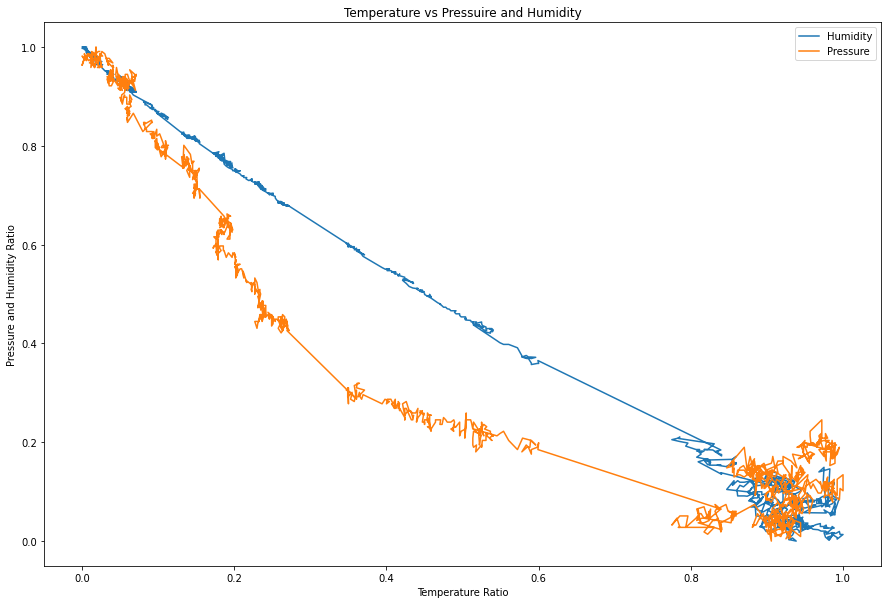

<Figure size 432x288 with 0 Axes>

In [6]:
def predict_humidity_from_temperature(t_value, message=True):
    reg = LinearRegression()
    X = temperature.values.reshape(-1, 1)
    y = humidity.values
    reg.fit(X, y)
    prediction = reg.predict(np.array([[t_value]]))
    
    if message:
        message = 'Prediction of humidity at 21 Celsius degrees: {0} %'.format(round(prediction[0], 2))
        return message
    else:
        return prediction[0]

def predict_pressure_from_temperature(t_value, message=True):
    reg = LinearRegression()
    X = temperature.values.reshape(-1, 1)
    y = pressure.values
    reg.fit(X, y)
    prediction = reg.predict(np.array([[t_value]]))
    
    if message:
        message = 'Prediction of pressure at 21 Celsius degrees: {0} hPa'.format(round(prediction[0], 2))
        return message
    else:
        return prediction[0]

satellite_data["formated_time"] = format_time(satellite_data, all_columns=True)
# print(satellite_data.head())

# time = satellite_data["formated_time"]
pressure = satellite_data["pressure"]
temperature = satellite_data["hdc_temperature"]
humidity = satellite_data["humidity"]

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

temperature_normalized = NormalizeData(temperature).values
humidity_normalized = NormalizeData(humidity).values
pressure_nomalized = NormalizeData(pressure).values

plt.figure(figsize=(15, 10))
plt.plot(temperature_normalized, humidity_normalized)
plt.plot(temperature_normalized, pressure_nomalized)
plt.title("Temperature vs Pressuire and Humidity")
plt.xlabel("Temperature Ratio")
plt.ylabel("Pressure and Humidity Ratio")
plt.legend(["Humidity", "Pressure"])
plt.show()
plt.clf()

### K-NEIGBORS MODEL
---

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
